In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import requests
from sklearn.metrics import f1_score, precision_score, recall_score 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

In [9]:
stopwords_list = requests.get(
    "https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [21]:
np.random.seed(500)

Corpus = pd.read_csv(
    r"Dataset.csv", encoding='latin-1')

In [22]:
# PREPROCESSING
# Step - a : Remove blank rows if any.
Corpus['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = [entry.lower() for entry in Corpus['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text'] = [word_tokenize(entry) for entry in Corpus['text']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index, entry in enumerate(Corpus['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index, 'text_final'] = str(Final_words)

In [23]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'], Corpus['label'], test_size=0.3)

In [24]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [25]:
Test_Y

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1])

In [26]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

#print(Tfidf_vect.vocabulary_)

In [27]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",
      accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  73.94957983193278


In [28]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  68.90756302521008


<Axes: >

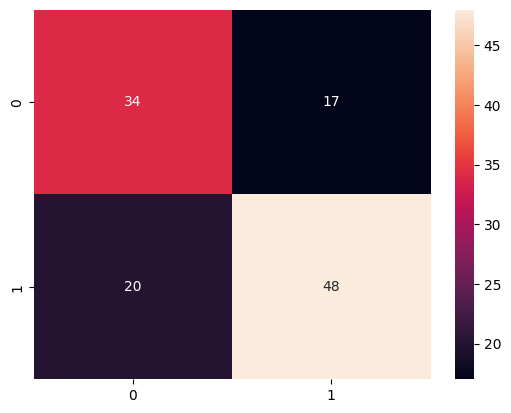

In [29]:
cf_matrix = confusion_matrix(predictions_SVM, Test_Y)
sns.heatmap(cf_matrix, annot=True)

In [30]:
print("Recall: ",round(recall_score(predictions_NB, Test_Y, pos_label=0)*100,1), "%")
print("Precision: ",round(precision_score(predictions_NB, Test_Y, pos_label=0)*100,1), "%")
print("F1-Score: ",round(f1_score(predictions_NB, Test_Y, pos_label=0)*100,1), "%")
print("Accuracy:",round(metrics.accuracy_score(predictions_NB, Test_Y)*100,1), "%")

Recall:  73.5 %
Precision:  66.7 %
F1-Score:  69.9 %
Accuracy: 73.9 %
